# Imports

In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torchmetrics import StructuralSimilarityIndexMeasure
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torchsummary import summary
import json
from tqdm import tqdm
from glob import glob
import sys
path = "/study3/mrphys/skunkworks/kk/mriUnet"
sys.path.insert(0,path)
import unet
from torchvision import transforms
from torch.utils.data import Dataset
import h5py
from sklearn.model_selection import KFold as kf
import os

allImages = sorted(glob("/study/mrphys/skunkworks/training_data//mover01/*/", recursive=True))

# Helper Functions

In [2]:
def slice2d(array, discardZero=False):
    '''
    slice a 4d array of shape (c-channel, n, n, n) where n in the cube length
    into 3d arrays slices of shape (c, n, n) per each 2d plane
    '''
    result = []
    c, w, h, d = array.shape
    assert (w==h)and(h==d)and(d==w), f"Array must be cubic, got: {w}x{h}x{d}"
    for i in range(w):
        result.append(array[:,i,:,:])
        result.append(array[:,:,i,:])
        result.append(array[:,:,:,i])
    return np.array(result)

def getComplexSlices(path, return_scale=False):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(6):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.max([np.abs(np.array(image['real'])).max(), np.abs(np.array(image['imag'])).max()])
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        imagesliceReal = slice2d(imagestackReal)
        imagesliceImag = slice2d(imagestackImag)
        
    if return_scale:
        return imagesliceReal+imagesliceImag*1j, normScale
    else:
        return imagesliceReal+imagesliceImag*1j
    
class mriDataset(Dataset):
    def __init__(self, sample, noisy=True):
        self.accelPathList = []
        self.accelFileList = []

        allImages = sorted(glob("/study/mrphys/skunkworks/training_data//mover01/*/", recursive=True))
        folderName  = allImages[sample]
        if noisy:
            self.accelPathList.append(folderName +'processed_data/acc_2min/C.h5')
        else:
            self.accelPathList.append(folderName +'processed_data/C.h5')
        
        for accelPath in self.accelPathList:
            slices, scale = getComplexSlices(accelPath, return_scale=True)
            self.accelFileList+= list(slices)
            self.scale = scale
            print('Image ' + accelPath + ' loaded')

    def __getitem__(self, index):
        return self.accelFileList[index]

    def __len__(self):
        return len(self.accelFileList)
    
def predict(model, dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), repeat=1):
    model.eval()
    model.to(device)
    X = []
    Y = []
    Z = []
    for i, noisy in tqdm(enumerate(dataset)):
        pred = torch.tensor(noisy).to(device).unsqueeze(0)
        with torch.no_grad():
            for _ in range(repeat):
                pred = model(pred)
            pred = pred.cpu().numpy() * dataset.scale
            if i%3==0:
                X.append(pred)
            elif i%3==1:
                Y.append(pred)
            else:
                Z.append(pred)
                
    return np.vstack(X).transpose(1,0,2,3), np.vstack(Y).transpose(1,2,0,3), np.vstack(Z).transpose(1,2,3,0)

# Prediction 

In [4]:
fold = 1

model = unet.UNet(
    6,
    6,
    f_maps=32,
    layer_order=['separable convolution', 'relu'],
    depth=3,
    layer_growth=2.0,
    residual=True,
    complex_input=True,
    complex_kernel=True,
    ndims=2,
    padding=1
)

name = f'slice_kfold_{fold}'

model.load_state_dict(torch.load(f'/study/mrphys/skunkworks/kk/outputs/{name}/weights/{name}_LATEST.pth'))

Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16)]


<All keys matched successfully>

In [5]:
idx = 4
noisy_dataset = mriDataset(idx)
original_dataset = mriDataset(idx, noisy=False)

Image /study/mrphys/skunkworks/training_data//mover01/M006/processed_data/acc_2min/C.h5 loaded
Image /study/mrphys/skunkworks/training_data//mover01/M006/processed_data/C.h5 loaded


In [7]:
X, Y, Z = predict(model, noisy_dataset, repeat=1)
pred = (X+Y+Z)/3

768it [00:31, 24.51it/s]


In [8]:
X, Y, Z = predict(model, noisy_dataset, repeat=0)
pred_null = (X+Y+Z)/3

X, Y, Z = predict(model, original_dataset, repeat=0)
pred_null2 = (X+Y+Z)/3

768it [00:02, 379.95it/s]
768it [00:01, 524.80it/s]


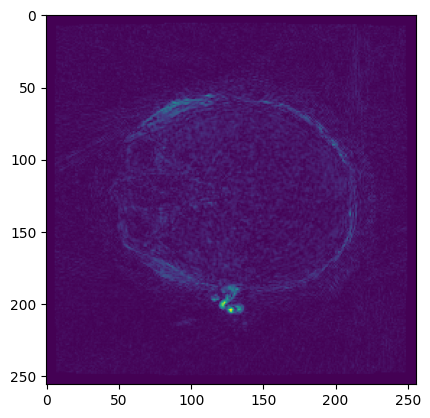

In [13]:
error = np.abs(pred_null2 - pred)
plt.imshow(np.abs(error)[0,100])

In [14]:
np.abs(error)[0,100]

array([[ 0.6955226 ,  2.0520077 ,  0.46578223, ...,  4.074604  ,
         4.5385427 ,  2.3512905 ],
       [ 0.7727528 ,  1.8676927 ,  2.1915338 , ...,  3.7283833 ,
         4.2966657 ,  3.3761783 ],
       [ 1.8860792 ,  4.418984  ,  3.744207  , ...,  3.448392  ,
         3.7655082 ,  3.2433143 ],
       ...,
       [ 1.0788251 ,  1.7038604 ,  1.531167  , ...,  7.041413  ,
         9.103373  ,  3.3430834 ],
       [ 2.3452806 ,  2.271935  ,  1.7462916 , ..., 12.1956415 ,
        10.966067  ,  3.3467677 ],
       [ 2.361743  ,  1.1667482 ,  0.90037334, ...,  7.193463  ,
         9.013729  ,  5.0686383 ]], dtype=float32)

In [ ]:
X, Y, Z = predict(model, original_dataset, repeat=1)
pred_original = (X+Y+Z)/3

X, Y, Z = predict(model, noisy_dataset, repeat=4)
pred_repeat = (X+Y+Z)/3

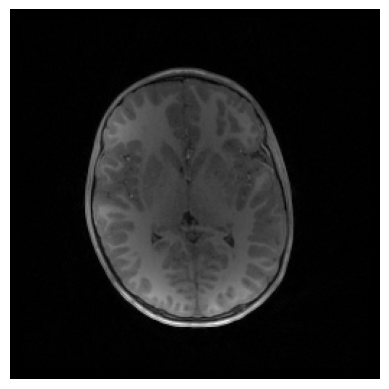

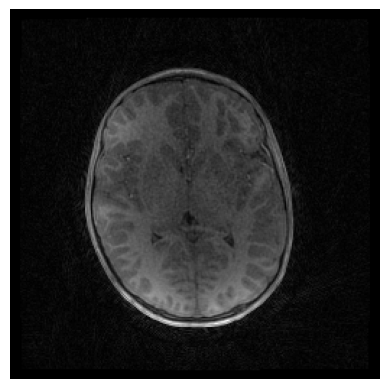

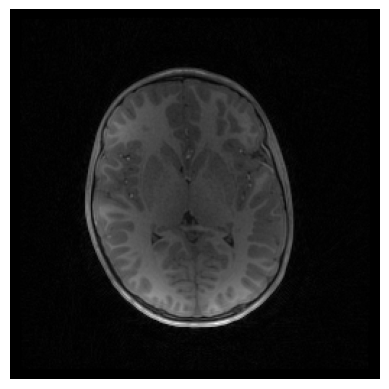

In [10]:
p = np.abs(pred)
plt.axis('off')
plt.gray()
n = 130
# plt.title("Top-down")
plt.imshow(p[0][n,:,:].swapaxes(1,0))
plt.show()
# plt.title("Left-right")
# plt.imshow(p[0][:,n,:])
# plt.show()
# plt.title("Front-back")
# plt.imshow(p[0][:,:,n])
# plt.show()

p = np.abs(pred_null)
plt.axis('off')
plt.gray()
# plt.title("Top-down")
plt.imshow(p[0][n,:,:].swapaxes(1,0))
plt.show()

p = np.abs(pred_null2)
plt.axis('off')
plt.gray()
# plt.title("Top-down")
plt.imshow(p[0][n,:,:].swapaxes(1,0))
plt.show()

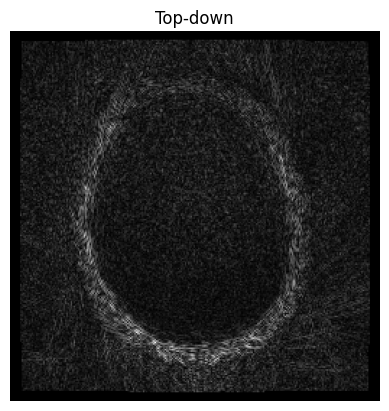

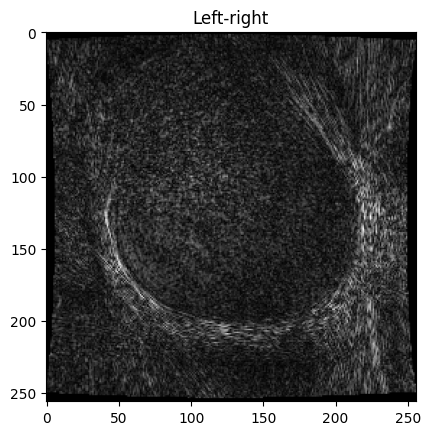

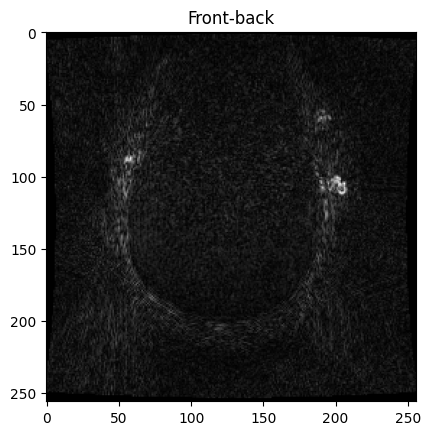

In [23]:
noise = pred_null2 - pred_null

p = np.abs(noise)
plt.axis('off')
plt.gray()
n = 120
c = 2

plt.title("Top-down")
plt.imshow(p[c][n,:,:].swapaxes(1,0))
plt.show()
plt.title("Left-right")
plt.imshow(p[0][:,n,:])
plt.show()
plt.title("Front-back")
plt.imshow(p[0][:,:,n])
plt.show()